In [1]:
import os
import cv2
import plotly.graph_objects as go

from utilities.ArUco_detector import visualize_detections_with_cross, get_marker_positions, add_cameras_to_fig, add_markers_markers_to_fig
from utilities.camera import load_cameras_from_json


In [2]:
calibration_file = 'calibration_dome.json'  # the calibrated camera params
input_base_path = "/data/vci/motion_markers"
sequence_name = "2026_01_29_motion_markers_001"
frame_range = 183

In [3]:
uppermost_view_names = ["C0025", "C0030", "C0024", "C0019", "C0031", "C0039"]
middle_view_names = ["C0007", "C0004", "C0006", "C0026", "C0028", "C0012",]
view_names = uppermost_view_names + middle_view_names

my_cameras = load_cameras_from_json(calibration_file, view_names)
scale = 0.5
for cam in my_cameras:
    cam.adjust_intrinsic_for_scale(scale)

In [4]:
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
aruco_params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)
detections = [[] for _ in range(len(view_names))]

frame_idx = 0
inputs = []
for i, view_name in enumerate(view_names):
    image_path = os.path.join(input_base_path,sequence_name,f"frame_{(frame_idx*2):05d}","rgb",f"{view_name}.png") # Load every two frames, 15 FPS is enough tp preview
    img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    corners, ids, rejected = detector.detectMarkers(img_bgr)
    inputs.append(img_rgb)
    
    # Store in the structure expected by your functions
    detections[i].append({
        "ids": ids,
        "corners": corners
    })

Found 9 markers. Visualizing with blue crosses.


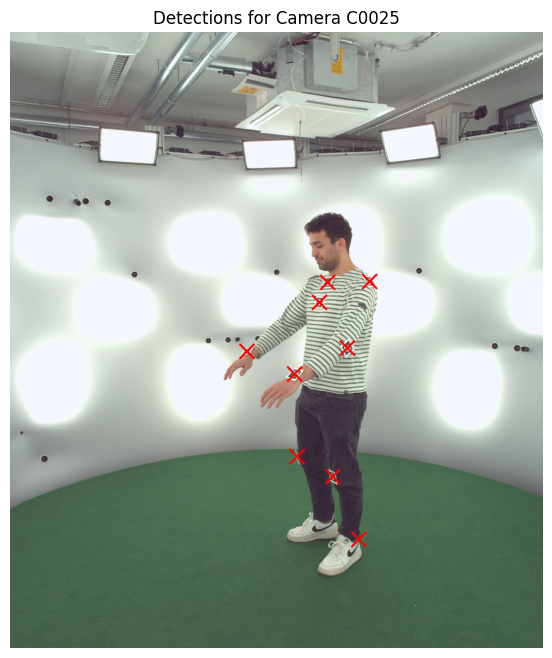

array([[[167, 200, 184],
        [169, 198, 181],
        [182, 196, 191],
        ...,
        [145, 161, 145],
        [138, 160, 148],
        [156, 156, 157]],

       [[183, 197, 192],
        [179, 196, 190],
        [166, 200, 183],
        ...,
        [159, 158, 155],
        [155, 157, 157],
        [154, 155, 156]],

       [[189, 195, 197],
        [188, 196, 191],
        [174, 202, 186],
        ...,
        [156, 156, 156],
        [151, 158, 156],
        [149, 158, 153]],

       ...,

       [[ 65, 102,  71],
        [ 75,  97,  72],
        [ 69,  92,  74],
        ...,
        [ 61, 106,  65],
        [ 66, 104,  71],
        [ 75,  97,  71]],

       [[ 71, 100,  76],
        [ 65,  95,  70],
        [ 63,  90,  71],
        ...,
        [ 61, 106,  65],
        [ 66, 104,  71],
        [ 75,  97,  71]],

       [[ 61,  96,  69],
        [ 45,  95,  69],
        [ 73,  89,  77],
        ...,
        [ 75, 100,  72],
        [ 71, 103,  66],
        [ 78, 100,  83]]

In [5]:
visualize_detections_with_cross(
    inputs[11], 
    detections[11][0], 
    title=f"Detections for Camera C0025"
)

In [6]:
marker_positions = get_marker_positions(
    detections=detections,
    cameras=my_cameras,
    input_is_undistorted=True
)

marker_positions

{0: {0: array([ 4.41559624, -4.90753216,  0.5286099 ]),
  1: array([ 0.30860589, -2.31949677, -2.68089574]),
  2: array([-1.44748858, -3.70074303, -2.71770441]),
  3: array([-4.75810927, 11.23051731,  3.02166862]),
  4: array([-0.45923204, -2.82671531,  3.01300393]),
  5: array([ 0.49170397, -4.23515549,  3.56573737]),
  6: array([-0.28959333, -0.39256981, -1.84309044]),
  7: array([-1.67796384,  6.74734541,  1.78374542]),
  9: array([-4.67800814, 11.24004018,  4.14380096]),
  10: array([  7.99456724, -11.98933041,  -0.77857526]),
  11: array([-8.50449039, 18.74532924,  3.71426975])}}

In [9]:
fig = go.Figure()
fig = add_cameras_to_fig(fig, my_cameras, scale=0.2)
fig = add_markers_markers_to_fig(fig, marker_positions)
fig.update_layout(
    title="VCI ArUco 3D Locations",
    scene=dict(
        xaxis_title='X (meters)',
        yaxis_title='Y (meters)',
        zaxis_title='Z (meters)',
        aspectmode='data',
        camera=dict(
            up=dict(x=0, y=-1, z=0),   # Sets the Z-axis to point 'up'
            eye=dict(x=1.5, y=1.5, z=1.5) # Initial camera position
        )
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()